In [1]:
import requests
import pandas as pd
import numpy as np
import ruptures as rpt
from collections import OrderedDict
import matplotlib.pyplot as plt
from datetime import date
import datetime

In [2]:
# Some European country names, wikidata-country codes, populations, school closures

# Remark: Not all country codes pulled out from wikidata will work for following reasons
    # 1. Sometimes there was not enough data before school closure
    # 2. Surprisingly, there were some typos in wikidata which made the reading difficult

    
country_names = []
country_codes = []
populations = []
school_closures = []

###############################
country_names.append("Austria") 
country_codes.append("Q86847911")
populations.append(8850000)
school_closures.append(date(2020, 3, 16)) 

###############################
country_names.append("Finland") 
country_codes.append("Q84055415")
populations.append(5500000)
school_closures.append(date(2020, 3, 18)) 

###############################
country_names.append("Germany") 
country_codes.append("Q83889294")
populations.append(83000000)
school_closures.append(date(2020, 3, 18)) 

###############################
country_names.append("Greece") 
country_codes.append("Q84055415")
populations.append(10700000)
school_closures.append(date(2020, 3, 11)) 

###############################
country_names.append("Italy") 
country_codes.append("Q84104992")
populations.append(60360000)
school_closures.append(date(2020, 3, 10)) 

###############################
country_names.append("Netherlands") 
country_codes.append("Q86756826")
populations.append(17000000)
school_closures.append(date(2020, 3, 16)) 

###############################
country_names.append("Portugal") 
country_codes.append("Q86948603")
populations.append(10300000)
school_closures.append(date(2020, 3, 16)) 

###############################
country_names.append("Spain") 
country_codes.append("Q84166704")
populations.append(47000000)
school_closures.append(date(2020, 3, 16)) 

###############################
country_names.append("United Kingdom") 
country_codes.append("Q84167106")
populations.append(67000000)
school_closures.append(date(2020, 3, 20)) 

In [3]:
# Define the lengths of different timeperiods: 
    # len_timeperiod1 = time considered before the school closure
    # len_timeperiod2 = time considered after the school closure 
len_timeperiod1 = 14
len_timeperiod2 = 28

# Penalty term for change point detection. 3.5 was chosen because with very often using this value we get 
# only one change point 
penalty = 3.5

In [4]:
# This function reads wikidata and outputs the daily increase of detected daily infections 
# for timeperiod [shutdown_ind - len_timeperiod1: shutdown_ind + len_timeperiod2], meaning some time
# before and after school closure

def return_series(index):
    url = 'https://query.wikidata.org/sparql'
    query = """
    SELECT
      ?nrcases ?timepoint
    WHERE {
     wd:%s p:P1603 ?p .
      ?p pq:P585 ?timepoint ;
         ps:P1603 ?nrcases .
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }
    """ % (country_codes[index])

    r = requests.get(url, params={'format': 'json', 'query': query}) #execute the query
    data = r.json()

    cases = []
    #cleans the data because some values are missing
    for item in data['results']['bindings']:
        cases.append(OrderedDict({'time': item['timepoint']['value'],
    'nrcases': item['nrcases']['value']
    }))

    df_wikidata=pd.DataFrame(cases)

    dates = df_wikidata['time'].values
    cases = df_wikidata['nrcases'].values

    for ind in list(range(len(cases))): 
        cases[ind] = int(cases[ind])
        dates[ind] = datetime.datetime.strptime(dates[ind],"%Y-%m-%dT%H:%M:%SZ")


    zipped_list = list(zip(dates, cases))
    zipped_list.sort(key=lambda tup: tup[0])

    dates = []
    cases = []
    for i in zipped_list:
       dates.append(i[0])
       cases.append(i[1])

    ts = pd.Series(cases,dates)
    ts = ts.resample('D').mean()
    ts = ts.interpolate()
    ts = ts.astype('int64')

    shutdown_ind = 0
    for i in range(len(ts.values)):
        if ts.index[i] == school_closures[index]:
            shutdown_ind = i
    
    obs_cum = ts.values[shutdown_ind - len_timeperiod1: shutdown_ind + len_timeperiod2]
    
    obs_increase = np.zeros(len(obs_cum))
    obs_increase[0] = (obs_cum[0] - ts.values[shutdown_ind - len_timeperiod1 -1]) / ts.values[shutdown_ind - len_timeperiod1 -1]
    ind = 1
    while ind <= len(obs_increase) - 1:
        obs_increase[ind] = (obs_cum[ind] - obs_cum[ind-1]) / obs_cum[ind-1]
        ind = ind + 1

    len_total_timeline = len_timeperiod1 + len_timeperiod2 + len_timeperiod2
    times = np.arange(len_total_timeline)
    
    return obs_increase

In [5]:
# Based on the obs_increase-data, this function will detect the chanhe points

def get_change_points(obs_increase ,index, penalty):
    
    obs_increase_reshaped = obs_increase.reshape(len(obs_increase), 1)

    algo = rpt.Pelt(model="rbf").fit(obs_increase_reshaped)
    changepoint = algo.predict(pen=penalty)

    return(changepoint)

Remark: Red line describes the school closure


Austria


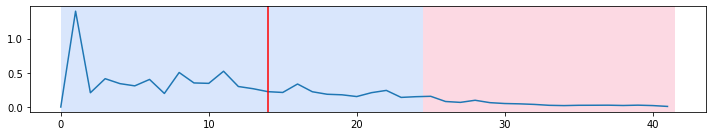

Finland


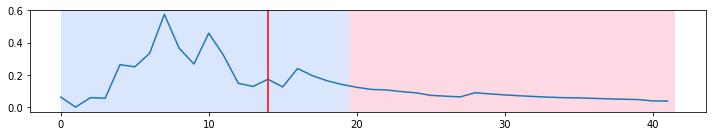

Germany


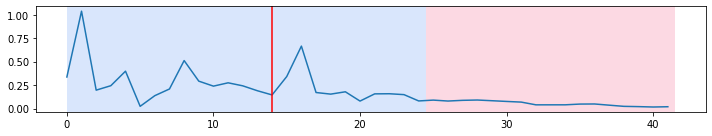

Greece


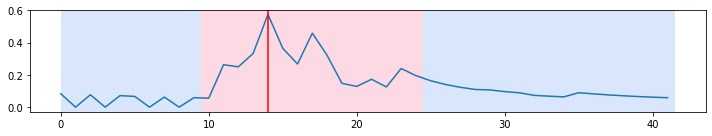

Italy


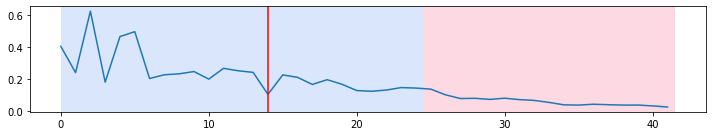

Netherlands


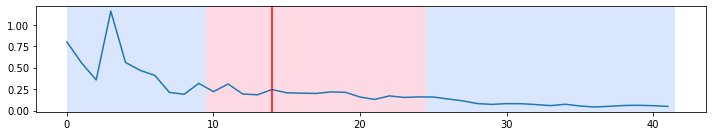

Portugal


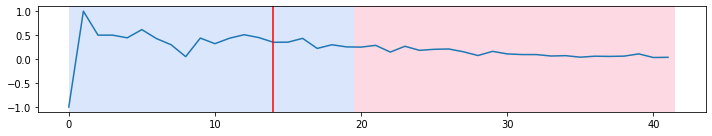

Spain


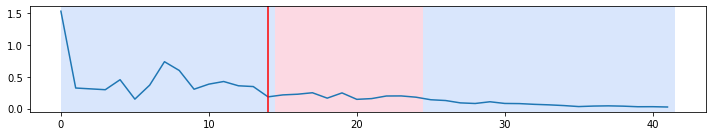

United Kingdom


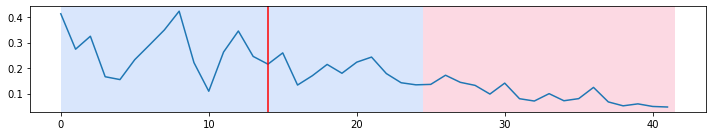

In [6]:
# We will count daily increases and change points and add them in vectors. Plotting also done

obs_increases = []
changepoints = []

print("Remark: Red line describes the school closure")
print("")
print("")

for i in range(len(country_names)):
    current_obs_increases = return_series(i)
    obs_increases.append(current_obs_increases)
    
    current_changepoint = get_change_points(current_obs_increases, i, penalty)
    changepoints.append(current_changepoint)
    
    print(country_names[i])
    rpt.display(current_obs_increases, current_changepoint)
    plt.axvline(len_timeperiod1, color='r')
    
    plt.show()